* * * 

<div align="Right">
  ©    Josefin Axberg 2017<br>
 </div>

# Final Project: Discovering the Enron Fraud

## Introduction

In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, there was a significant amount of typically confidential information entered into public record, including tens of thousands of emails and detailed financial data for top executives. In this project, I will play detective, and put my new skills to use by building a person of interest identifier based on financial and email data made public as a result of the Enron scandal. I use email and financial data for 146 executives at Enron to identify persons of interest in the fraud case. A person of interest (POI) is someone who was indicted for fraud, settled with the government, or testified in exchange for immunity. This report documents the machine learning techniques used in building a POI identifier.
There are four major steps in my project:
1. **Explore data**
2. **Feature engineering**
3. **Classifiers**
4. **Validation**

![](enron.jpg)

In [149]:
import time
print("Today is %s" % time.strftime("%Y-%m-%d"))

Today is 2017-12-14


In [195]:
#!/usr/bin/python

import os
import pickle
import re
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Let me start with the loading of the data and see how it is structured.

In [151]:
# Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

my_dataset = data_dict
df_enron = pd.DataFrame(my_dataset) # Load pickle data to DataFrame for feature enginering etc
df_enron = df_enron.T               # Setting names as indexes and features as columns


df_enron.head()

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
ALLEN PHILLIP K,4175000,2869717,-3081055,NaN,phillip.allen@enron.com,1729541,13868,2195,47,65,...,304805,152,False,126027,-126027,201955,1407,2902,4484442,1729541
BADUM JAMES P,NaN,178980,NaN,NaN,NaN,257817,3486,NaN,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,182466,257817
BANNANTINE JAMES M,NaN,NaN,-5104,NaN,james.bannantine@enron.com,4046157,56301,29,39,0,...,NaN,864523,False,1757552,-560222,477,465,566,916197,5243487
BAXTER JOHN C,1200000,1295738,-1386055,NaN,NaN,6680544,11200,NaN,NaN,NaN,...,1586055,2660303,False,3942714,NaN,267102,NaN,NaN,5634343,10623258
BAY FRANKLIN R,400000,260455,-201641,NaN,frank.bay@enron.com,NaN,129142,NaN,NaN,NaN,...,NaN,69,False,145796,-82782,239671,NaN,NaN,827696,63014


In [152]:
df_enron.describe()

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
count,146,146,146,146,146,146,146,146,146,146,...,146,146,146,146,146,146,146,146,146,146
unique,42,40,45,18,112,102,95,65,58,42,...,53,93,2,98,19,95,84,87,126,125
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,64,107,97,129,35,44,51,60,60,60,...,80,53,128,36,128,51,60,60,21,20


In [153]:
df_enron.shape

(146, 21)

In [154]:
print "There are ", len(data_dict.keys()), " executives in Enron Dataset."

There are  146  executives in Enron Dataset.


In [155]:
print data_dict.keys()

['METTS MARK', 'BAXTER JOHN C', 'ELLIOTT STEVEN', 'CORDES WILLIAM R', 'HANNON KEVIN P', 'MORDAUNT KRISTINA M', 'MEYER ROCKFORD G', 'MCMAHON JEFFREY', 'HORTON STANLEY C', 'PIPER GREGORY F', 'HUMPHREY GENE E', 'UMANOFF ADAM S', 'BLACHMAN JEREMY M', 'SUNDE MARTIN', 'GIBBS DANA R', 'LOWRY CHARLES P', 'COLWELL WESLEY', 'MULLER MARK S', 'JACKSON CHARLENE R', 'WESTFAHL RICHARD K', 'WALTERS GARETH W', 'WALLS JR ROBERT H', 'KITCHEN LOUISE', 'CHAN RONNIE', 'BELFER ROBERT', 'SHANKMAN JEFFREY A', 'WODRASKA JOHN', 'BERGSIEKER RICHARD P', 'URQUHART JOHN A', 'BIBI PHILIPPE A', 'RIEKER PAULA H', 'WHALEY DAVID A', 'BECK SALLY W', 'HAUG DAVID L', 'ECHOLS JOHN B', 'MENDELSOHN JOHN', 'HICKERSON GARY J', 'CLINE KENNETH W', 'LEWIS RICHARD', 'HAYES ROBERT E', 'MCCARTY DANNY J', 'KOPPER MICHAEL J', 'LEFF DANIEL P', 'LAVORATO JOHN J', 'BERBERIAN DAVID', 'DETMERING TIMOTHY J', 'WAKEHAM JOHN', 'POWERS WILLIAM', 'GOLD JOSEPH', 'BANNANTINE JAMES M', 'DUNCAN JOHN H', 'SHAPIRO RICHARD S', 'SHERRIFF JOHN R', 'SHELBY 

In [156]:
people = data_dict.keys()

# Explore Data

First I would like to visually look at the data and check if it contains any NaN values and/or outliers. 

### Exploring NaN-values

In [157]:
df_enron = df_enron.replace('NaN', np.nan)

In [158]:
print "Amount of NaN values in the dataset: ", df_enron.isnull().sum().sum()


df_enron.loc[(df_enron['email_address'].isnull()) |
              (df_enron['deferral_payments'].isnull()) |
              (df_enron['bonus'].isnull()) |
              (df_enron['from_messages'].isnull())].sample(10)

Amount of NaN values in the dataset:  1358


,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
LEWIS RICHARD,NaN,NaN,NaN,NaN,richard.lewis@enron.com,850477.0,NaN,26.0,10.0,0.0,...,NaN,NaN,False,NaN,NaN,NaN,739.0,952.0,NaN,850477.0
OVERDYKE JR JERE C,NaN,NaN,NaN,NaN,jere.overdyke@enron.com,5266578.0,18834.0,NaN,NaN,NaN,...,135836.0,176.0,False,2041016.0,NaN,94941.0,NaN,NaN,249787.0,7307594.0
HUMPHREY GENE E,NaN,2964506.0,NaN,NaN,gene.humphrey@enron.com,2282768.0,4994.0,17.0,10.0,17.0,...,NaN,NaN,False,NaN,NaN,130724.0,119.0,128.0,3100224.0,2282768.0
BADUM JAMES P,NaN,178980.0,NaN,NaN,NaN,257817.0,3486.0,NaN,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,182466.0,257817.0
BANNANTINE JAMES M,NaN,NaN,-5104.0,NaN,james.bannantine@enron.com,4046157.0,56301.0,29.0,39.0,0.0,...,NaN,864523.0,False,1757552.0,-560222.0,477.0,465.0,566.0,916197.0,5243487.0
BERGSIEKER RICHARD P,250000.0,NaN,-485813.0,NaN,rick.bergsieker@enron.com,NaN,59175.0,59.0,4.0,0.0,...,180250.0,427316.0,False,659249.0,NaN,187922.0,233.0,383.0,618850.0,659249.0
WODRASKA JOHN,NaN,NaN,NaN,NaN,john.wodraska@enron.com,NaN,NaN,NaN,NaN,NaN,...,NaN,189583.0,False,NaN,NaN,NaN,NaN,NaN,189583.0,NaN
DODSON KEITH,70000.0,NaN,NaN,NaN,keith.dodson@enron.com,NaN,28164.0,14.0,10.0,3.0,...,NaN,774.0,False,NaN,NaN,221003.0,114.0,176.0,319941.0,NaN
BROWN MICHAEL,NaN,NaN,NaN,NaN,michael.brown@enron.com,NaN,49288.0,41.0,13.0,1.0,...,NaN,NaN,False,NaN,NaN,NaN,761.0,1486.0,49288.0,NaN
HORTON STANLEY C,NaN,3131860.0,NaN,NaN,stanley.horton@enron.com,5210569.0,NaN,1073.0,44.0,15.0,...,NaN,NaN,False,2046079.0,NaN,NaN,1074.0,2350.0,3131860.0,7256648.0


In [159]:
# Explore missing data
print(df_enron.isnull().sum())

bonus                         64
deferral_payments            107
deferred_income               97
director_fees                129
email_address                 35
exercised_stock_options       44
expenses                      51
from_messages                 60
from_poi_to_this_person       60
from_this_person_to_poi       60
loan_advances                142
long_term_incentive           80
other                         53
poi                            0
restricted_stock              36
restricted_stock_deferred    128
salary                        51
shared_receipt_with_poi       60
to_messages                   60
total_payments                21
total_stock_value             20
dtype: int64


In [160]:
def q1_missing_vals_plot(dft):
    x = dft.isnull().sum(axis=1)
    y = dft.index.values
    t = dft.shape[1]
    s = pd.Series((x/t)*100, index=y).sort_values(ascending=False)

    sns.set(style="whitegrid", font_scale=1.0, rc={"figure.figsize": (16, 12)})
    ax = sns.barplot(orient='h', x=s, y=s.index, palette="GnBu_d")
    ax.set(title="Missing value ratio per feature")
    plt.show()

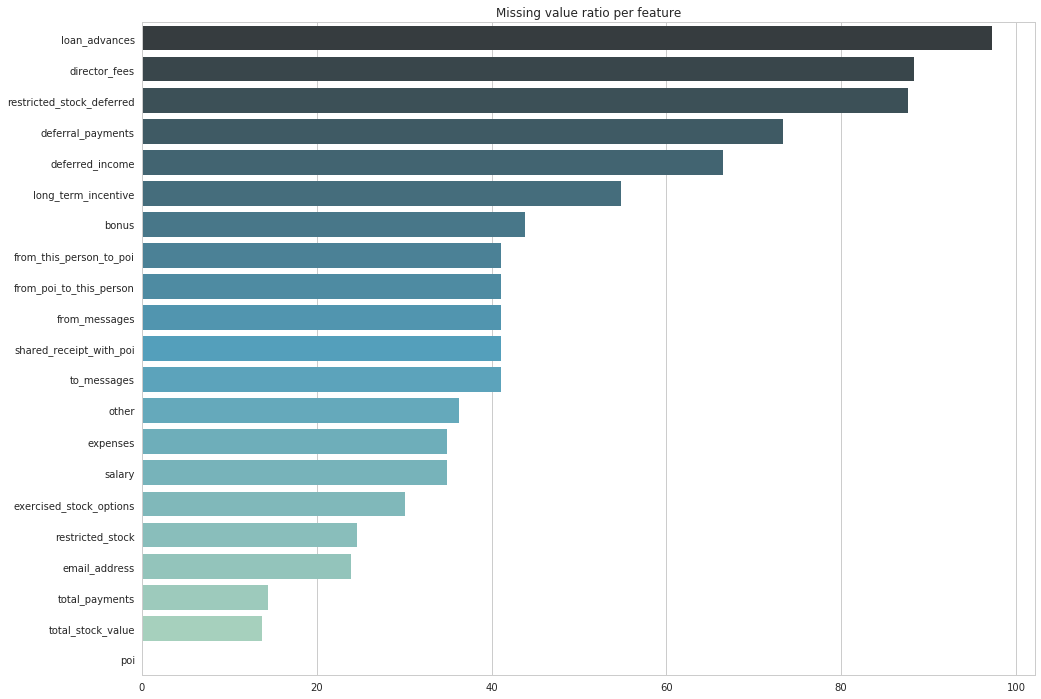

In [161]:
q1_missing_vals_plot(df_enron.T)

As investigated there are a lot of NaN's in my data. In some features there is relevant to drop the entire feature but in some of them I can set NaN to 0 och NaN to mean etc. 

In [162]:
# First I am going to drop the features that according to my analysis aren't relevant to predict POIs
df_enron = df_enron.drop(['email_address', 'other', 'long_term_incentive', 'deferral_payments', 'restricted_stock_deferred', 'deferred_income'], axis=1)

df_enron.head(5)

,bonus,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,poi,restricted_stock,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
ALLEN PHILLIP K,4175000.0,NaN,1729541.0,13868.0,2195.0,47.0,65.0,NaN,False,126027.0,201955.0,1407.0,2902.0,4484442.0,1729541.0
BADUM JAMES P,NaN,NaN,257817.0,3486.0,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,182466.0,257817.0
BANNANTINE JAMES M,NaN,NaN,4046157.0,56301.0,29.0,39.0,0.0,NaN,False,1757552.0,477.0,465.0,566.0,916197.0,5243487.0
BAXTER JOHN C,1200000.0,NaN,6680544.0,11200.0,NaN,NaN,NaN,NaN,False,3942714.0,267102.0,NaN,NaN,5634343.0,10623258.0
BAY FRANKLIN R,400000.0,NaN,NaN,129142.0,NaN,NaN,NaN,NaN,False,145796.0,239671.0,NaN,NaN,827696.0,63014.0


In [163]:
cols_with_zero = ['director_fees', 'bonus', 'from_this_person_to_poi', 'from_poi_to_this_person', 'loan_advances', 'restricted_stock', 'shared_receipt_with_poi', 'to_messages', 'from_messages', 'exercised_stock_options']
df_enron[cols_with_zero] = df_enron[cols_with_zero].fillna(0)


df_enron.head(5)

,bonus,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,poi,restricted_stock,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
ALLEN PHILLIP K,4175000.0,0.0,1729541.0,13868.0,2195.0,47.0,65.0,0.0,False,126027.0,201955.0,1407.0,2902.0,4484442.0,1729541.0
BADUM JAMES P,0.0,0.0,257817.0,3486.0,0.0,0.0,0.0,0.0,False,0.0,NaN,0.0,0.0,182466.0,257817.0
BANNANTINE JAMES M,0.0,0.0,4046157.0,56301.0,29.0,39.0,0.0,0.0,False,1757552.0,477.0,465.0,566.0,916197.0,5243487.0
BAXTER JOHN C,1200000.0,0.0,6680544.0,11200.0,0.0,0.0,0.0,0.0,False,3942714.0,267102.0,0.0,0.0,5634343.0,10623258.0
BAY FRANKLIN R,400000.0,0.0,0.0,129142.0,0.0,0.0,0.0,0.0,False,145796.0,239671.0,0.0,0.0,827696.0,63014.0


In [164]:
cols_with_mean = ['salary', 'total_payments', 'total_stock_value', 'expenses']
df_enron[cols_with_mean] = df_enron[cols_with_mean].fillna(df_enron[cols_with_mean].mean())

df_enron.head(5)

,bonus,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,poi,restricted_stock,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
ALLEN PHILLIP K,4175000.0,0.0,1729541.0,13868.0,2195.0,47.0,65.0,0.0,False,126027.0,201955.000000,1407.0,2902.0,4484442.0,1729541.0
BADUM JAMES P,0.0,0.0,257817.0,3486.0,0.0,0.0,0.0,0.0,False,0.0,562194.294737,0.0,0.0,182466.0,257817.0
BANNANTINE JAMES M,0.0,0.0,4046157.0,56301.0,29.0,39.0,0.0,0.0,False,1757552.0,477.000000,465.0,566.0,916197.0,5243487.0
BAXTER JOHN C,1200000.0,0.0,6680544.0,11200.0,0.0,0.0,0.0,0.0,False,3942714.0,267102.000000,0.0,0.0,5634343.0,10623258.0
BAY FRANKLIN R,400000.0,0.0,0.0,129142.0,0.0,0.0,0.0,0.0,False,145796.0,239671.000000,0.0,0.0,827696.0,63014.0


In [165]:
# Confirm that no missing data is left
print(df_enron.isnull().sum())

bonus                      0
director_fees              0
exercised_stock_options    0
expenses                   0
from_messages              0
from_poi_to_this_person    0
from_this_person_to_poi    0
loan_advances              0
poi                        0
restricted_stock           0
salary                     0
shared_receipt_with_poi    0
to_messages                0
total_payments             0
total_stock_value          0
dtype: int64


### Exploring Outliers

In [166]:
#sns.pairplot(df_enron.sample(20), hue='poi')

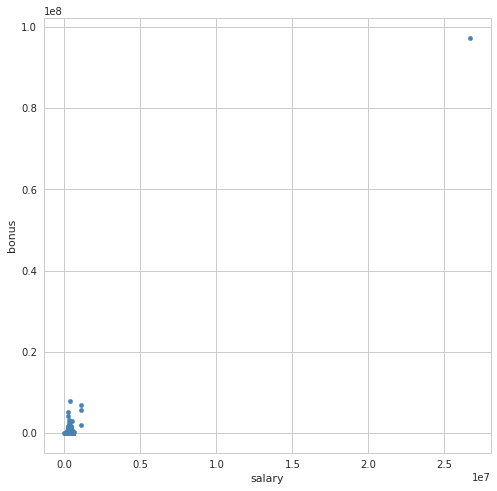

In [167]:
df_enron.plot.scatter(x='salary', y='bonus', color='steelblue', figsize=(8, 8))

The outlier here must be the row "Total". 

In [168]:
# Remove any outliers before proceeding further

df_enron = df_enron.loc[(df_enron['bonus'] < 10000000)] # This removes the row 'Total'

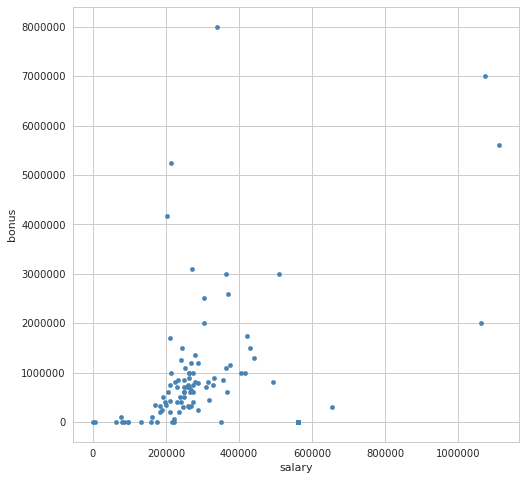

In [169]:
# Plot without 'Total'
df_enron.plot.scatter(x='salary', y='bonus', color='steelblue', figsize=(8, 8))

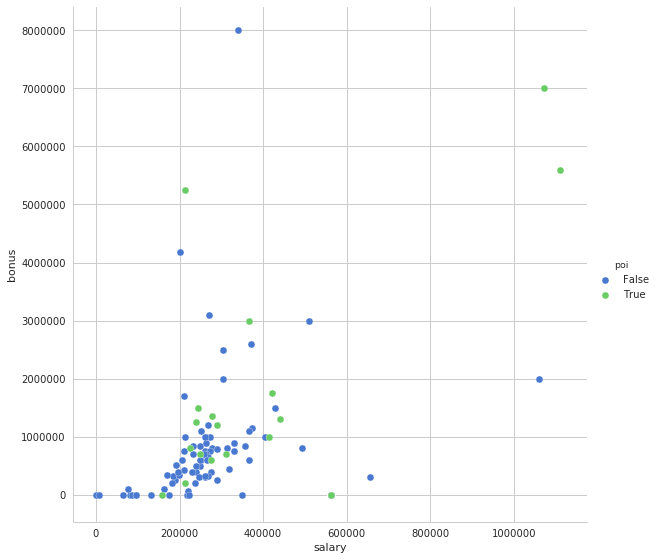

In [170]:
sns.pairplot(x_vars=["salary"], y_vars=["bonus"], data=df_enron, hue="poi", size=8, palette='muted')

Hm... why does a non-POI have that much in bonus but still a quite common salary?

In [171]:
df_enron.loc[(df_enron['bonus'] == 8000000)]

,bonus,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,poi,restricted_stock,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
LAVORATO JOHN J,8000000.0,0.0,4158995.0,49537.0,2585.0,528.0,411.0,0.0,False,1008149.0,339288.0,3962.0,7259.0,10425757.0,5167144.0


After researching on Lavorato it seems that he was a part of the inner circle on Enron and got paid to keep him from leaving the company during its last fall. This is kind of strange but considering that he is not that famous and that he is not a POI, he won't help the modell to predict POIs. Therefore I have decided to exclude him from the dataset.

In [172]:
# Drop Lavorato and also the Travel agency in the park which can't be a POI
df_enron = df_enron.drop(['LAVORATO JOHN J','THE TRAVEL AGENCY IN THE PARK'],0)

In [173]:
df_enron.loc[(df_enron['bonus'] == 0) & (df_enron['poi'] == True)]

,bonus,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,poi,restricted_stock,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
HIRKO JOSEPH,0.0,0.0,30766064.0,77978.0,0.0,0.0,0.0,0.0,True,0.0,562194.294737,0.0,0.0,91093.0,30766064.0
YEAGER F SCOTT,0.0,0.0,8308552.0,53947.0,0.0,0.0,0.0,0.0,True,3576206.0,158403.000000,0.0,0.0,360300.0,11884758.0


The bonus for this to POIs was not given and is therefore 0 in my case. That is not great but something I have to live with and something I think the modell will handle due to that they have valuble other features.

It is also one point in the plot that seems to have a very high salary but low bonus. Let me look futher into this....

In [174]:
df_enron.loc[(df_enron['salary'] > 1000000)]

,bonus,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,poi,restricted_stock,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
FREVERT MARK A,2000000.0,0.0,10433518.0,86987.0,21.0,242.0,6.0,2000000.0,False,4188667.0,1060932.0,2979.0,3275.0,17252530.0,14622185.0
LAY KENNETH L,7000000.0,0.0,34348384.0,99832.0,36.0,123.0,16.0,81525000.0,True,14761694.0,1072321.0,2411.0,4273.0,103559793.0,49110078.0
SKILLING JEFFREY K,5600000.0,0.0,19250000.0,29336.0,108.0,88.0,30.0,0.0,True,6843672.0,1111258.0,2042.0,3627.0,8682716.0,26093672.0


After researching Frevert it seems that he are not so well known but one of the top managers at Enron. He seems to have a lot other valuble features so I have decided to keep him in the dataset.

# Feature engineering

It is time for feature engineering and feature correlation. Which features will be a good idea to later include in the model...?

### Feature Correlation

Check feature relevance/importance through correlation between them. 

**Correlation:** The value of the correlation coefficient ranges from -1 to 1, where 1 means fully correlated and 0 implies no relation, or independent variables. Negative correlations imply that the variables are anti-correlated. Perfectly anti-correlated variables have a correlation of -1 and are as good for predictive purposes as positive (1) correlation. 
Correlations around 0 are useless for forecasting but a correlaion slighly higher or lower than 0 can still make sense when doing prediction.


When performing correlation there are mainly three different methods for doing this:
1. Pearson Correlation Coefficient
2. Spearman's Correlation
3. Kendall's Tau

**Pearson:** Measures the **linear** association between continuous variables. In other words, this coefficient quantifies the degree to which a relationship between two variables can be described by a line.

**Spearman:** Spearman's correlation is not restricted to linear relationships. Instead, it measures **monotonic association** (only strictly increasing or decreasing, but not mixed) between two variables and relies on the rank order of values. In other words, rather than comparing means and variances, Spearman's coefficient looks at the relative order of values for each variable. This makes it appropriate to use with both continuous and discrete data.

**Kendall:** Kendalls' τ does not take into account the difference between ranks — only directional agreement. Therefore, this coefficient is more appropriate for discrete data. It is just the number of possible combinations of pairs, which ensures that τ varies between 1 and -1. When using Kendall's τ you should have data where the relative position of data points is more important that difference between them.

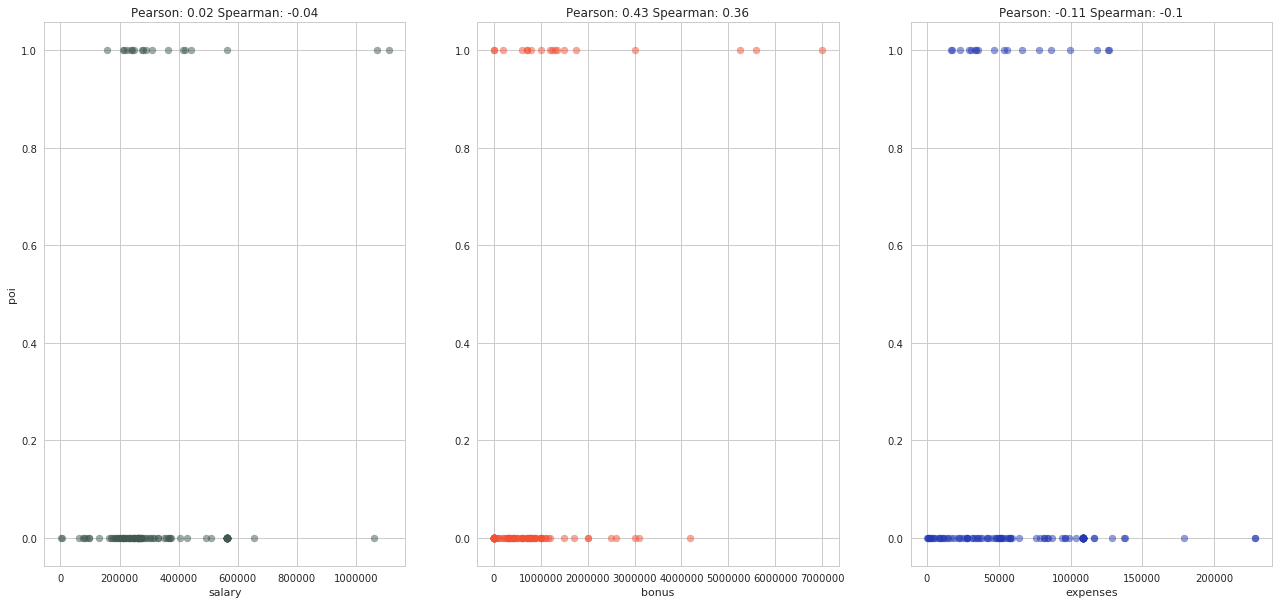

In [175]:
# Plot the correlated values for three features in our dataset
plt.rcParams['figure.figsize'] = [22, 10]

fig, ax = plt.subplots(nrows=1, ncols=3)

ax=ax.flatten()

cols = ['salary', 'bonus', 'expenses']
colors=['#415952', '#f35134', '#243AB5', '#243AB5']
j=0

for i in ax:
    if j==0:
        i.set_ylabel('poi')
    i.scatter(df_enron[cols[j]], df_enron['poi'],  alpha=0.5, color=colors[j])
    i.set_xlabel(cols[j])
    i.set_title('Pearson: %s'%df_enron.corr().loc[cols[j]]['poi'].round(2)+' Spearman: %s'%df_enron.corr(method='spearman').loc[cols[j]]['poi'].round(2))
    j+=1

plt.show()

The best correlated feature among these three seems to be the feature 'bonus'.  I am going to exclude the other ones. 

### New Features

It doesen't matter how many emails you send/recive but if most of the emails you send/recive are to/from a POI you are most likely a POI yourself. Let's create a feature that does this.

In [176]:
df_enron["fraction_from_poi"] = df_enron['from_this_person_to_poi']/df_enron['from_messages']
df_enron['fraction_to_poi'] = df_enron['from_poi_to_this_person']/df_enron['to_messages']

df_enron.head(5)

,bonus,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,poi,restricted_stock,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,fraction_from_poi,fraction_to_poi
ALLEN PHILLIP K,4175000.0,0.0,1729541.0,13868.0,2195.0,47.0,65.0,0.0,False,126027.0,201955.000000,1407.0,2902.0,4484442.0,1729541.0,0.029613,0.016196
BADUM JAMES P,0.0,0.0,257817.0,3486.0,0.0,0.0,0.0,0.0,False,0.0,562194.294737,0.0,0.0,182466.0,257817.0,NaN,NaN
BANNANTINE JAMES M,0.0,0.0,4046157.0,56301.0,29.0,39.0,0.0,0.0,False,1757552.0,477.000000,465.0,566.0,916197.0,5243487.0,0.000000,0.068905
BAXTER JOHN C,1200000.0,0.0,6680544.0,11200.0,0.0,0.0,0.0,0.0,False,3942714.0,267102.000000,0.0,0.0,5634343.0,10623258.0,NaN,NaN
BAY FRANKLIN R,400000.0,0.0,0.0,129142.0,0.0,0.0,0.0,0.0,False,145796.0,239671.000000,0.0,0.0,827696.0,63014.0,NaN,NaN


In [177]:
# View new NaN's
print(df_enron.isnull().sum())

bonus                       0
director_fees               0
exercised_stock_options     0
expenses                    0
from_messages               0
from_poi_to_this_person     0
from_this_person_to_poi     0
loan_advances               0
poi                         0
restricted_stock            0
salary                      0
shared_receipt_with_poi     0
to_messages                 0
total_payments              0
total_stock_value           0
fraction_from_poi          58
fraction_to_poi            58
dtype: int64


In [178]:
# I got NaN if the person's from_messages = 0, I am going to remove these NaN's
df_enron = df_enron.fillna(0)

df_enron.head(5)

,bonus,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,poi,restricted_stock,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,fraction_from_poi,fraction_to_poi
ALLEN PHILLIP K,4175000.0,0.0,1729541.0,13868.0,2195.0,47.0,65.0,0.0,False,126027.0,201955.000000,1407.0,2902.0,4484442.0,1729541.0,0.029613,0.016196
BADUM JAMES P,0.0,0.0,257817.0,3486.0,0.0,0.0,0.0,0.0,False,0.0,562194.294737,0.0,0.0,182466.0,257817.0,0.000000,0.000000
BANNANTINE JAMES M,0.0,0.0,4046157.0,56301.0,29.0,39.0,0.0,0.0,False,1757552.0,477.000000,465.0,566.0,916197.0,5243487.0,0.000000,0.068905
BAXTER JOHN C,1200000.0,0.0,6680544.0,11200.0,0.0,0.0,0.0,0.0,False,3942714.0,267102.000000,0.0,0.0,5634343.0,10623258.0,0.000000,0.000000
BAY FRANKLIN R,400000.0,0.0,0.0,129142.0,0.0,0.0,0.0,0.0,False,145796.0,239671.000000,0.0,0.0,827696.0,63014.0,0.000000,0.000000


### Feature Selection

When I study the dataset these are a few features that feels more relevant in predicting POIs than others. Let me make these features to a list.

In [179]:
# Features_list is a list of strings, each of which is a feature name.
# The first feature must be "poi".

feature_list = ["poi", "bonus", "fraction_from_poi", "fraction_to_poi", 'total_payments', 'loan_advances', 'total_stock_value']

# Classifiers

**Pick the algorithm**: One of the basic classifiers used in machine learning is a Decision Tree classifier. It can preform well on few features and do not need a huge amount of data. It asks Yes/No questions about the data and each time getting closer to classfying the data. 
Random Forest is a type of Decision Tree but creates many trees and train on randomized part of the training data in order to avoid overfitting. I also tried Gaussian Naive Bayse but it did not achive as good as the two recently mentioned. 

In [180]:
# Create the classifier and show the result of the best preforming one

clf = DecisionTreeClassifier()
#clf = RFC(n_estimators=10)
#clf = GaussianNB()
clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [181]:
features = ["bonus", "fraction_from_poi", "fraction_to_poi", 'total_payments','loan_advances', 'total_stock_value', 'exercised_stock_options']

In [182]:
# Sklearn assumes data to be present in lists
# We therefore need to convert our data into lists, 'values' attribute does that

X = df_enron[features].values
Y = df_enron['poi'].values

# To check
features[:5]

['bonus',
 'fraction_from_poi',
 'fraction_to_poi',
 'total_payments',
 'loan_advances']

In [183]:
# Splits the data into training and testing sets based on 
(training_inputs, testing_inputs, training_scores, testing_scores) = train_test_split(X, Y, test_size=0.25, random_state= 1)

In [184]:
clf.fit(training_inputs, training_scores);
pred = clf.predict(testing_inputs)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [185]:
print "Accuracy:", clf.score(testing_inputs, testing_scores)

Accuracy: 0.916666666667


## Tune the algorithm

In [186]:
param_grid = {'max_depth': np.arange(3, 10)}

tree = GridSearchCV(DecisionTreeClassifier(), param_grid)

tree.fit(training_inputs, training_scores)
tree_preds = tree.predict_proba(testing_inputs)[:, 1]
tree_performance = roc_auc_score(testing_scores, tree_preds)

print 'DecisionTree: Area under the ROC curve = {}'.format(tree_performance)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': array([3, 4, 5, 6, 7, 8, 9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

DecisionTree: Area under the ROC curve = 0.9765625


In [187]:
decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {'max_depth': [1, 2, 3, 4, 5],
                  'max_features': [1, 2, 3, 4]}

cross_validation = StratifiedKFold(Y, n_folds=10)

grid_search = GridSearchCV(decision_tree_classifier, param_grid = parameter_grid,
                          cv = cross_validation)

grid_search.fit(X, Y)

print "Best Score: {}".format(grid_search.best_score_)
print "Best params: {}".format(grid_search.best_params_)

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[False False ...,  True False], n_folds=10, shuffle=False, random_state=None),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': [1, 2, 3, 4], 'max_depth': [1, 2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Best Score: 0.895104895105
Best params: {'max_features': 2, 'max_depth': 3}


In [188]:
grid_search.best_params_

{'max_depth': 3, 'max_features': 2}

# Validation

Before consider the prodject to be done I need to validate the preformance of my model. I have decided to do that with Precision and Recall, Cross Validation and a ROC-curve.

In [189]:
df_feature_importance = pd.DataFrame({'feature': df_enron[features].columns, 'importance':clf.feature_importances_})
df_feature_importance.sort_values(by="importance", ascending=False)

,feature,importance
1,fraction_from_poi,0.306956
0,bonus,0.207371
6,exercised_stock_options,0.193863
3,total_payments,0.140491
5,total_stock_value,0.080878
2,fraction_to_poi,0.070441
4,loan_advances,0.000000


In [190]:
print "Precision:", precision_score(testing_scores, pred)
print "Recall:", recall_score(testing_scores, pred)

Precision: 0.6
Recall: 0.75


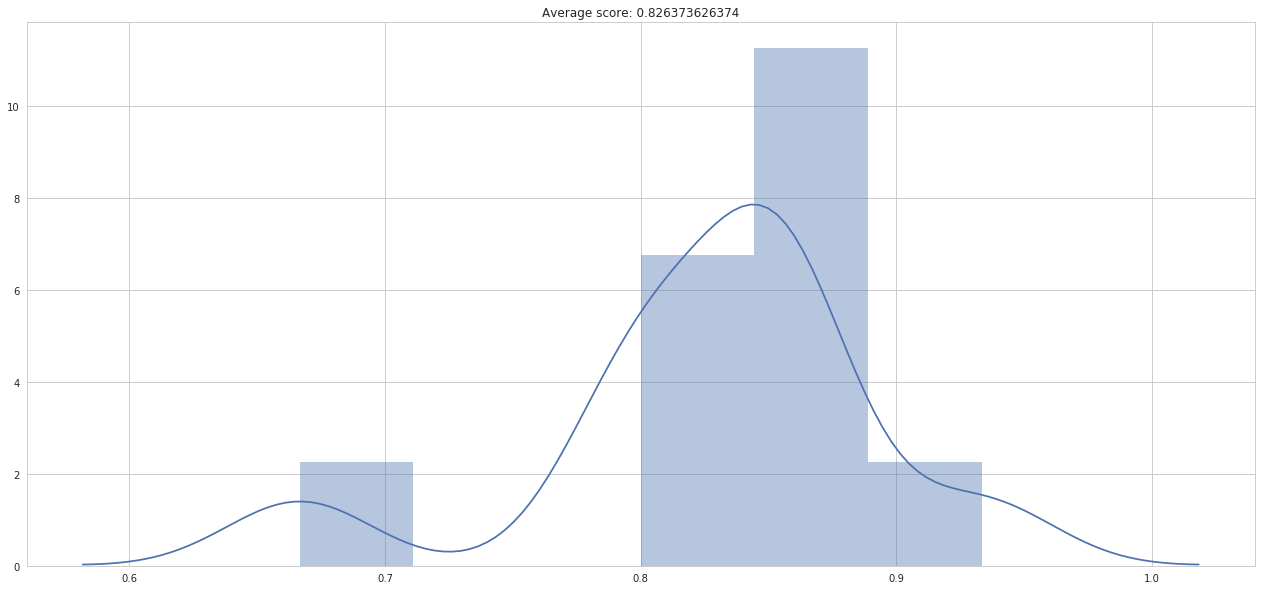

In [191]:
from sklearn.cross_validation import cross_val_score

decision_tree_classifier = DecisionTreeClassifier()

# cross_val_score returns a list of the scores, which we can visualize
# to get a reasonable estimate of our classifier's performance
cv_scores = cross_val_score(decision_tree_classifier, X, Y, cv=10)
sns.distplot(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

ROC AUC: 0.84


(0.0, 1.0)

(0.0, 1.05)

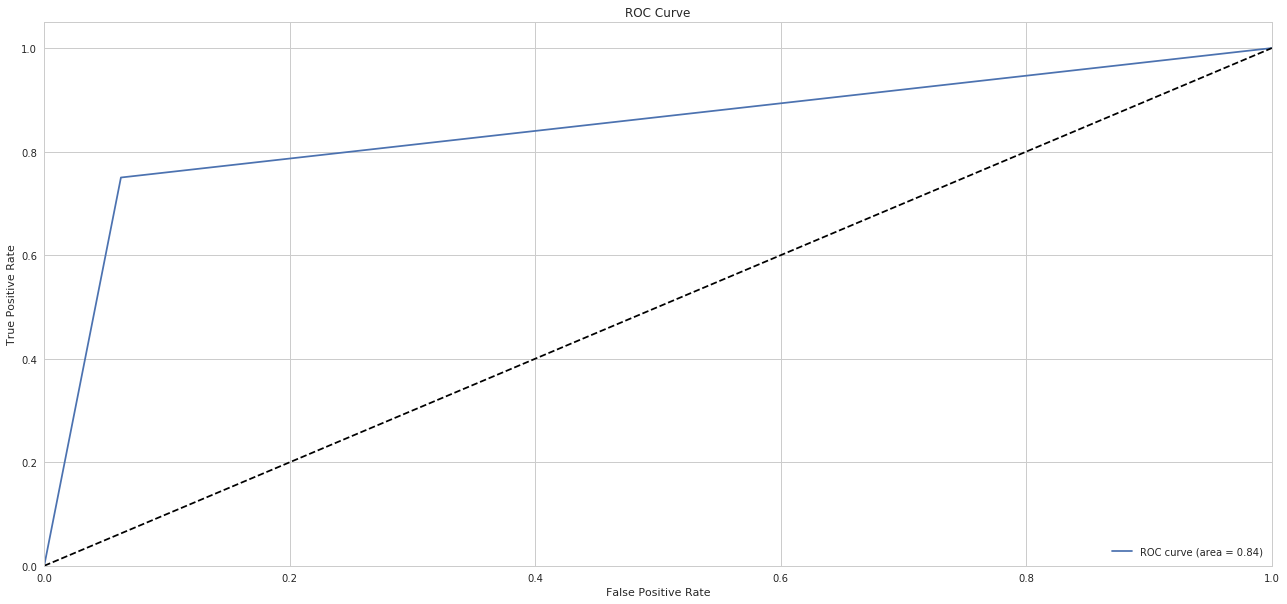

In [192]:
# Determine the false positive and true positive rates
fpr, tpr, _ = roc_curve(testing_scores, clf.predict_proba(testing_inputs)[:,1])
 
# Calculate the AUC
roc_auc = auc(fpr, tpr)
print ('ROC AUC: %0.2f' % roc_auc)
 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [193]:
# Dump the classifier, dataset and features_list so anyone can run/check your results
pickle.dump(clf, open("my_classifier.pkl", "w") )
pickle.dump(data_dict, open("my_dataset.pkl", "w") )
pickle.dump(features, open("my_feature_list.pkl", "w") )

In [194]:
#!jupyter nbconvert --to script FinalProject_TheEnronFraud.ipynb

### References:
- https://github.com/raishish/ml-projects/blob/master/Iris_Classification/Iris%20Classification.ipynb
- https://arjan-hada.github.io/enron-fraud.html
